In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import copy

import ase.io

# from utils.librascal import RascalSphericalExpansion
from utils.rascaline import RascalineSphericalExpansion
from utils.models.soap import compute_power_spectrum

In [3]:
frames = ase.io.read("data/molecule_conformers_dftb.xyz", ":100")

# frames = ase.io.read("selection-10k.extxyz", "::100")
for frame in frames:
    frame.pbc = [False, False, False]
    frame.cell = [0, 0, 0]
    # frame.cell = [100, 100, 100]
    # frame.center()

training_frames, testing_frames = sklearn.model_selection.train_test_split(
    frames, train_size=0.8, random_state=0XDEADBEEF, 
)


train_energies = np.array([
    frame.info["energy"] for frame in training_frames
])

train_forces = np.vstack([
    frame.arrays["forces"] for frame in training_frames
])

test_energies = np.array([
    frame.info["energy"] for frame in testing_frames
])

test_forces = np.vstack([
    frame.arrays["forces"] for frame in testing_frames
])

In [4]:
RASCAL_HYPERS = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 6,
    "max_angular": 6,
    "gaussian_sigma_type": "Constant",
    "gaussian_sigma_constant": 0.3,
}

# def compute_spherical_expansion(frames, gradients=False):
#     hypers = copy.deepcopy(RASCAL_HYPERS)
#     hypers["compute_gradients"] = gradients
    
#     calculator = RascalSphericalExpansion(hypers)
#     return calculator.compute(frames)

RASCALINE_HYPERS = {
    "cutoff": RASCAL_HYPERS["interaction_cutoff"],
    "atomic_gaussian_width": RASCAL_HYPERS["gaussian_sigma_constant"],
    "max_radial": RASCAL_HYPERS["max_radial"],
    "max_angular": RASCAL_HYPERS["max_angular"],
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": RASCAL_HYPERS["cutoff_smooth_width"]}},
    "center_atom_weight": 1.0,
}

TRAIN_WITH_FORCES = False

def compute_spherical_expansion(frames, gradients=False):
    hypers = copy.deepcopy(RASCALINE_HYPERS)
    hypers["gradients"] = gradients
    
    calculator = RascalineSphericalExpansion(hypers)
    return calculator.compute(frames)

# Check kernels vs librascal

In [5]:
from utils.models.utils import dot, power, structure_sum, normalize

check_frames = [frame.copy() for frame in training_frames[::10]]

spx = compute_spherical_expansion(check_frames)
ps = compute_power_spectrum(spx)

ps.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
ps.keys_to_samples('center_species')

ps = normalize(ps)
kernel = power(dot(ps, ps, do_normalize=False), zeta=2)

structure_kernel = structure_sum(kernel, sum_properties=True)

In [6]:
from rascal.representations import SphericalInvariants
from rascal.models import Kernel as RascalKernel

rascal_calculator = SphericalInvariants(
    normalize=True, 
    soap_type="PowerSpectrum", 
    compute_gradients=True,
    **RASCAL_HYPERS
)

for frame in check_frames:
    frame.cell = [100, 100, 100]
    frame.center()

managers = rascal_calculator.transform(check_frames)

rascal_ps = managers.get_features(rascal_calculator)
rascal_kernel_per_atom = np.power(rascal_ps @ rascal_ps.T, 2)
rascal_kernel = np.zeros((len(check_frames), len(check_frames)))

start_i = 0
for i, frame_1 in enumerate(check_frames):
    stop_i = start_i + len(frame_1)
    
    start_j = 0
    for j, frame_2 in enumerate(check_frames):
        stop_j = start_j + len(frame_2)
        rascal_kernel[i, j] = np.sum(rascal_kernel_per_atom[start_i:stop_i, start_j:stop_j])
        start_j = stop_j

    start_i = stop_i
        

# This is using mean instead of sum for reduction
# rascal_kernel_fn = RascalKernel(
#     rascal_calculator, 
#     name="Cosine", 
#     kernel_type="Full",
#     target_type="Structure",
#     zeta=1
# )

In [7]:
assert np.allclose(rascal_kernel, structure_kernel.block().values)

# Training models

In [8]:
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual.flatten() - predicted.flatten())**2))

def parity_plot(energies, predicted_energies, forces, predicted_forces):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    loss = rmse(energies, predicted_energies)
    x = [energies.min(), energies.max()]
    ax[0].plot(x, x, color="r")
    ax[0].scatter(energies, predicted_energies)
    ax[0].set_title(f"Energy — RMSE = {1000 * loss:.4} meV")

    loss = rmse(forces.flatten(), predicted_forces.flatten())
    x = [forces.flatten().min(), forces.flatten().max()]
    ax[1].plot(x, x, color="r")
    ax[1].scatter(forces.flatten(), predicted_forces.flatten())
    ax[1].set_title(f"Forces — RMSE = {1000 * loss:.4} meV/A")

In [9]:
def check_finite_differences(model, frame, delta=1e-6, keys_to_samples=True):
    frame = frame.copy()

    spx = compute_spherical_expansion(frame, gradients=True)
    ps = compute_power_spectrum(spx)
    ps.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
    if keys_to_samples:
        ps.keys_to_samples('center_species')
    energy, forces = model.predict(ps, with_forces=True)

    frame.positions[3, 1] += delta
    spx_delta = compute_spherical_expansion(frame, gradients=True)
    ps_delta = compute_power_spectrum(spx_delta)
    ps_delta.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
    if keys_to_samples: 
        ps_delta.keys_to_samples('center_species')

    energy_delta, _ = model.predict(ps_delta, with_forces=True)

    finite_diff = - (energy_delta[0, 0] - energy[0, 0]) / delta
    print("finite difference =", finite_diff)
    print("computed gradient =", forces[3, 1])

In [10]:
train_spx = compute_spherical_expansion(training_frames, gradients=True)
train_ps = compute_power_spectrum(train_spx)
train_ps.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
train_ps.keys_to_samples('center_species')


test_spx = compute_spherical_expansion(testing_frames, gradients=True)
test_ps = compute_power_spectrum(test_spx)
test_ps.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
test_ps.keys_to_samples('center_species')


train_spx_no_grad = compute_spherical_expansion(training_frames, gradients=False)
train_ps_no_grad = compute_power_spectrum(train_spx_no_grad)
train_ps_no_grad.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
train_ps_no_grad.keys_to_samples('center_species')

## Train a linear regression model

In [11]:
from utils.models.linear import LinearModel

In [12]:
model = LinearModel(normalize=True, regularizer=[1e-4, 5e-4])

if TRAIN_WITH_FORCES:
    model.fit(train_ps, train_energies, train_forces)
else:
    model.fit(train_ps_no_grad, train_energies)

In [13]:
check_finite_differences(model, testing_frames[0], delta=1e-5)

finite difference = -0.21880362055526345
computed gradient = -0.2186791575353272


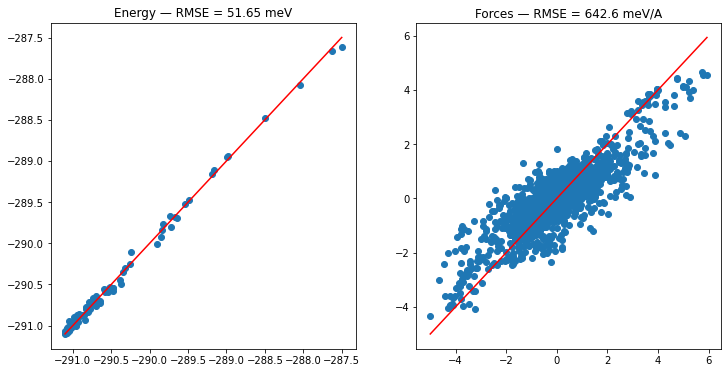

In [14]:
predicted_e, predicted_f = model.predict(train_ps, with_forces=True)

parity_plot(train_energies, predicted_e, train_forces, predicted_f)

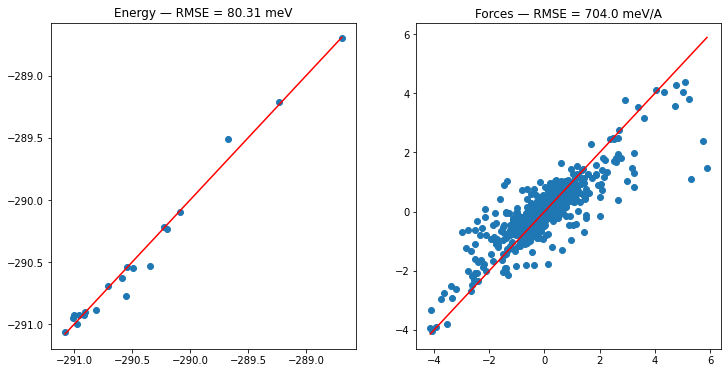

In [15]:
predicted_e, predicted_f = model.predict(test_ps, with_forces=True)

parity_plot(test_energies, predicted_e, test_forces, predicted_f)

## Train a GAP model with full kernel

In [16]:
from utils.models.full_kernel import FullKernelGap

In [17]:
model = FullKernelGap(zeta=2, regularizer=[1e-2, 1e-2])

if TRAIN_WITH_FORCES:
    print("can not train full kernel with forces yet")

model.fit(train_ps_no_grad, train_energies)

In [18]:
check_finite_differences(model, testing_frames[0], delta=1e-6)

finite difference = -0.2383002311034943
computed gradient = -0.23828967174005955


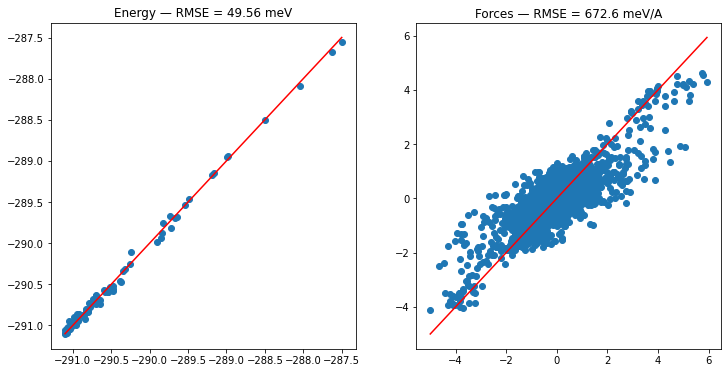

In [19]:
predicted_e, predicted_f = model.predict(train_ps, with_forces=True)

parity_plot(train_energies, predicted_e, train_forces, predicted_f)

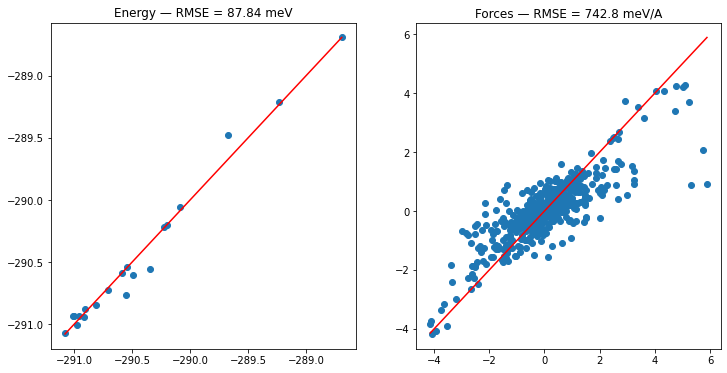

In [20]:
predicted_e, predicted_f = model.predict(test_ps, with_forces=True)

parity_plot(test_energies, predicted_e, test_forces, predicted_f)

## Sparse kernels

In [21]:
from utils.models.sparse_kernel import select_support_points, SparseKernelGap

In [22]:
support = select_support_points(train_ps, n_select=80)

print(support.block().values.shape)

(80, 1512)


In [23]:
model = SparseKernelGap(support_points=support, zeta=1, regularizer=[1e-2, 5e-2])

if TRAIN_WITH_FORCES:
    model.fit(train_ps, train_energies, train_forces)
else:
    model.fit(train_ps_no_grad, train_energies)

In [24]:
check_finite_differences(model, testing_frames[0], delta=1e-6)

finite difference = 1.0980438673868775
computed gradient = 1.0980791908368843


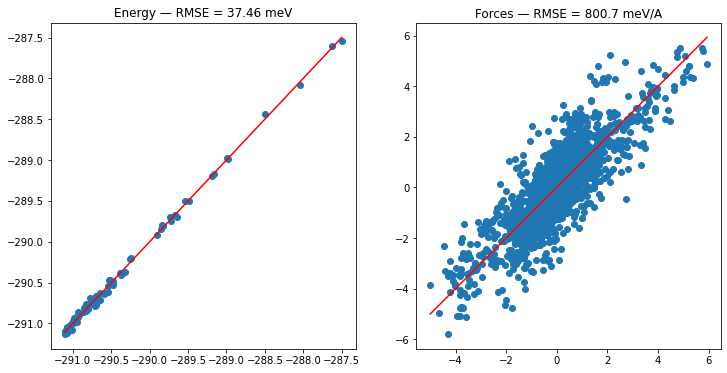

In [25]:
predicted_e, predicted_f = model.predict(train_ps, with_forces=True)

parity_plot(train_energies, predicted_e, train_forces, predicted_f)

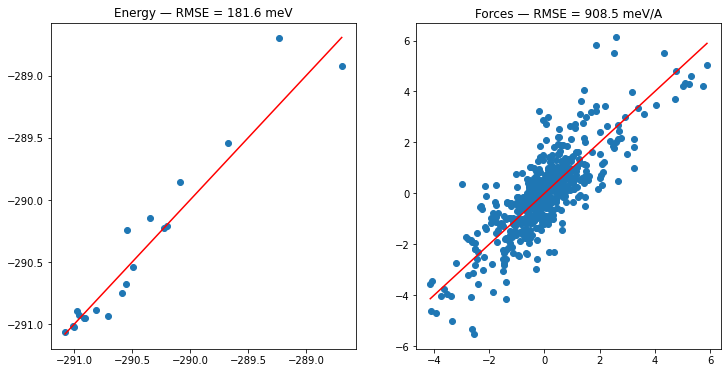

In [26]:
predicted_e, predicted_f = model.predict(test_ps, with_forces=True)

parity_plot(test_energies, predicted_e, test_forces, predicted_f)

## Sparse kernel with different support point per central species

In [27]:
train_ps_per_species = compute_power_spectrum(train_spx)
train_ps_per_species.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])

train_ps_per_species_no_grad = compute_power_spectrum(train_spx_no_grad)
train_ps_per_species_no_grad.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])

test_ps_per_species = compute_power_spectrum(test_spx)
test_ps_per_species.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])

In [28]:
n_select = {
    center_species: 0
    for center_species in train_ps_per_species.keys.as_namedtuples()
}

n_select[(1,)] = 30
n_select[(6,)] = 30
n_select[(8,)] = 20

support = select_support_points(train_ps_per_species, n_select=n_select)

In [29]:
model = SparseKernelGap(support_points=support, zeta=2, regularizer=[1e-2, 1e-2])

if TRAIN_WITH_FORCES:
    model.fit(train_ps_per_species, train_energies, train_forces)
else:
    model.fit(train_ps_per_species_no_grad, train_energies)

In [30]:
check_finite_differences(model, testing_frames[0], delta=1e-6, keys_to_samples=False)

finite difference = 1.6982694432954304
computed gradient = 1.6983162325585397


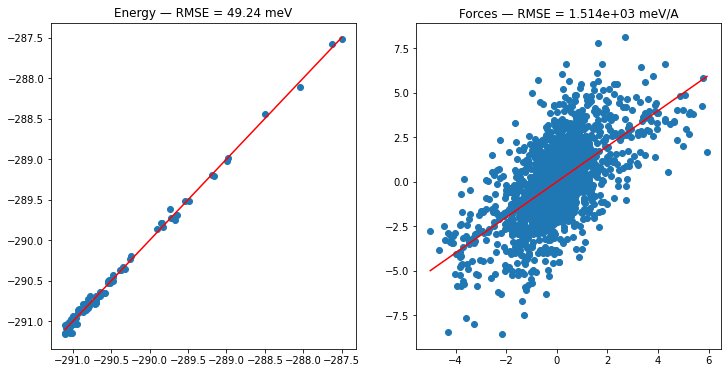

In [31]:
predicted_e, predicted_f = model.predict(train_ps_per_species, with_forces=True)

parity_plot(train_energies, predicted_e, train_forces, predicted_f)

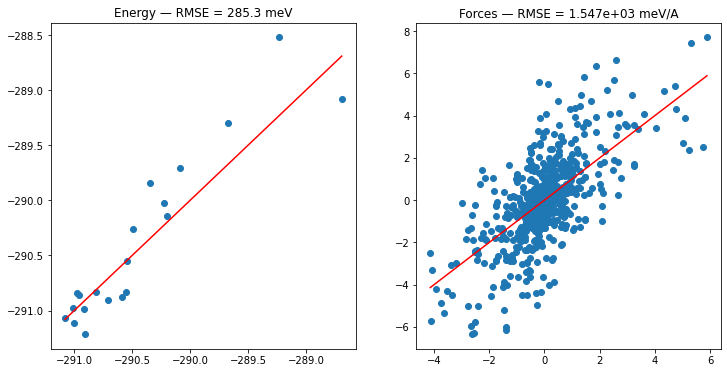

In [32]:
predicted_e, predicted_f = model.predict(test_ps_per_species, with_forces=True)

parity_plot(test_energies, predicted_e, test_forces, predicted_f)